## **Notebook 2: Introduction to RAPIDS**

The following content is from:
    https://github.com/rapidsai-community/notebooks-contrib/blob/main/getting_started_materials/intro_tutorials_and_guides/01_Introduction_to_RAPIDS.ipynb

Let's load some helper functions from matplotlib and configure the Jupyter Notebook for visualization.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

ImportError: libjpeg.so.62: cannot open shared object file: No such file or directory

---

**GPU-Accelerated Data Manipulation with CuDF**

*Pandas*

Data scientists typically work with two types of data: unstructured and structured. Unstructured data often comes in the form of text, images, or videos. Structured data - as the name suggests - comes in a structured form, often represented by a table or CSV. We'll focus the majority of these tutorials on working with these types of data.

There exist many tools in the Python ecosystem for working with structured, tabular data but few are as widely used as Pandas. Pandas represents data in a table and allows a data scientist to manipulate the data to perform a number of useful operations such as filtering, transforming, aggregating, merging, visualizing and many more.

For more information on Pandas, check out the excellent documentation: http://pandas.pydata.org/pandas-docs/stable/

Below we show how to create a Pandas DataFrame, an internal object for representing tabular data.

In [3]:
import pandas as pd; print('Pandas Version:', pd.__version__)

Pandas Version: 1.5.0


In [4]:
# here we create a Pandas DataFrame with
# two columns named "key" and "value"
df = pd.DataFrame()
df['key'] = [0, 0, 2, 2, 3]
df['value'] = [float(i + 10) for i in range(5)]
print(df)

   key  value
0    0   10.0
1    0   11.0
2    2   12.0
3    2   13.0
4    3   14.0


We can perform many operations on this data. For example, let's say we wanted to sum all values in the in the value column. We could accomplish this using the following syntax:

In [5]:
aggregation = df['value'].sum()
print(aggregation)

60.0


*cuDF*

Pandas is fantastic for working with small datasets that fit into your system's memory. However, datasets are growing larger and data scientists are working with increasingly complex workloads - the need for accelerated compute arises.

cuDF is a package within the RAPIDS ecosystem that allows data scientists to easily migrate their existing Pandas workflows from CPU to GPU, where computations can leverage the immense parallelization that GPUs provide.

Below, we show how to create a cuDF DataFrame.

In [6]:
import cudf; print('cuDF Version:', cudf.__version__)

cuDF Version: 22.10.00


In [7]:
# here we create a cuDF DataFrame with
# two columns named "key" and "value"
df = cudf.DataFrame()
df['key'] = [0, 0, 2, 2, 3]
df['value'] = [float(i + 10) for i in range(5)]
print(df)

   key  value
0    0   10.0
1    0   11.0
2    2   12.0
3    2   13.0
4    3   14.0


As before, we can take this cuDF DataFrame and perform a sum operation over the value column. The key difference is that any operations we perform using cuDF use the GPU instead of the CPU.

In [8]:
aggregation = df['value'].sum()
print(aggregation)

60.0


Note how the syntax for both creating and manipulating a cuDF DataFrame is identical to the syntax necessary to create and manipulate Pandas DataFrames; the cuDF API is based on the Pandas API. This design choice minimizes the cognitive burden of switching from a CPU based workflow to a GPU based workflow and allows data scientists to focus on solving problems while benefitting from the speed of a GPU!

*Comparing the Performance of CuDF and Pandas*

Let's try increasing our data size a bit, giving our system more numbers to crunch through.

In [9]:
%%time
import pandas as pd 
import numpy as np 

pandas_df = pd.DataFrame({'a': np.random.randint(0, 100000000, size=10000000),
                          'b': np.random.randint(0, 100000000, size=10000000)})

pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   a       int64
 1   b       int64
dtypes: int64(2)
memory usage: 152.6 MB
CPU times: user 290 ms, sys: 77.3 ms, total: 367 ms
Wall time: 424 ms


Now our dataset is just over 150 MB in size. A very modest size for the GPU, but still show us great speedups with reasonable completion time. Try increasing the problem size for even bigger GPU speedups, but note that the operations can quickly become intractable for the CPU to complete.

For now, let's replicate the dataframe on the GPU. To construct the cudf dataframe, we could simply used the `pandas_df` dataframe directly.

`cudf_df = cudf.DataFrame.from_pandas(pandas_df)`

But instead, let's initialize our data with CuPy to show off the interoperability with CuDF dataframes! Modify the following cell to initialize the dataframe with CuPy.

In [10]:
%%time
import pandas as pd 
import numpy as np 

#pandas_df = pd.DataFrame({'a': np.random.randint(0, 100000000, size=10000000),
#                          'b': np.random.randint(0, 100000000, size=10000000)})

cudf_df.info()

NameError: name 'cudf_df' is not defined

Click the `...` below to reveal the solution.

In [11]:
%%time
import cupy as cp

cudf_df = cudf.DataFrame({'a': cp.random.randint(0, 100000000, size=10000000),
                          'b': cp.random.randint(0, 100000000, size=10000000)})

cudf_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   a       int64
 1   b       int64
dtypes: int64(2)
memory usage: 152.6 MB
CPU times: user 2.85 s, sys: 463 ms, total: 3.31 s
Wall time: 5.4 s


Notice how quickly the CuDF dataframe was created compared to the Pandas dataframe. Now that we have our dataframes in both CPU and GPU memory, let's do some data analysis and manipulation to see see what kind of speedups are possible with GPU acceleration!

First, let's try some operations that will touch every data element in the dataframe. A great setup for parallel GPU processing!

In [12]:
%timeit pandas_df.a.mean()
%timeit cudf_df.a.mean()

14.7 ms ± 38.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
438 µs ± 6.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%timeit pandas_df.a.max()
%timeit cudf_df.a.max()

10.6 ms ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
426 µs ± 4.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Let's look at some sort and merge operations, which are often computationally expensive and can really show off the power of CuDF.

_Merge_

In [14]:
%timeit pandas_df.merge(pandas_df, on='b')
%timeit cudf_df.merge(cudf_df, on='b')

6.12 s ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
57.2 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


_Sort_

In [15]:
%timeit pandas_df.sort_values('b')
%timeit cudf_df.sort_values('b')

KeyboardInterrupt: 

_GroupBy_

In [ ]:
%timeit pandas_df.groupby(by=['b']).sum()
%timeit cudf_df.groupby(by=['b']).sum()

*A Quick Note on Data Interoperability*

The data stored in CuDF dataframes is interoperable with major data analytics and deep learning frameworks in the Python ecosystem. Including Tensorflow, Pytorch, CuPy, and the other tools we'll be talking about next - Numba. This interoperability is largely made possible by DLPack - a standardized specification for tensor structures. And shuttling the data between different applications is done without any memory copies! This will become increasingly powerful as you start to learn more about the possibilities to integrate GPUs into your own workflows! Let's make a quick pit stop to get hands-on experience with DLPack. 

In [ ]:
import cudf
import cupy as cp

cp_array = cp.array([100, 200, 300], cp.int32)

#Convert  cp.ndarray -> DLpack
dlp_array = cp_array.toDlpack()

#Convert DLpack -> cudf.dataframe
cudf_df = cudf.from_dlpack(dlp_array)
print(cudf_df)

---

**GPU-Accelerated Machine Learning with CuML**

*Scikit-Learn*

After our data has been preprocessed, we often want to build a model so as to understand the relationships between different variables in our data. Scikit-Learn is an incredibly powerful toolkit that allows data scientists to quickly build models from their data. Below we show a simple example of how to create a Linear Regression model.

In [10]:
import numpy as np; print('NumPy Version:', np.__version__)


# create the relationship: y = 2.0 * x + 1.0
n_rows = 1000000 # let's use 1M data points
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(n_rows,))
b = 1.0
y = w * x + b

# add a bit of noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

NumPy Version: 1.22.0


We can now visualize our data using the matplotlib library. Let's plot the first 10,000 data points.

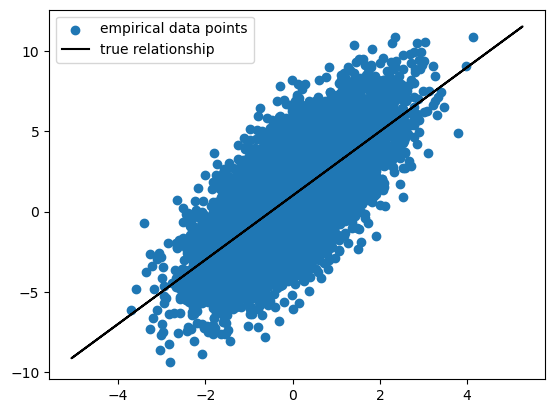

In [13]:
plt.scatter(x[:10000], y_noisy[:10000], label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

We'll use the LinearRegression class from Scikit-Learn to instantiate a model and fit it to our data.

In [14]:
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression


# instantiate and fit model
linear_regression = LinearRegression()

Scikit-Learn Version: 0.24.2


In [15]:
%%time

linear_regression.fit(np.expand_dims(x, 1), y)

CPU times: user 28.5 ms, sys: 13.9 ms, total: 42.4 ms
Wall time: 57.2 ms


LinearRegression()

In [16]:
# create new data and perform inference
inputs = np.linspace(start=-5, stop=5, num=1000)
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

Let's now visualize our empirical data points, the true relationship of the data, and the relationship estimated by the model. Looks pretty close!



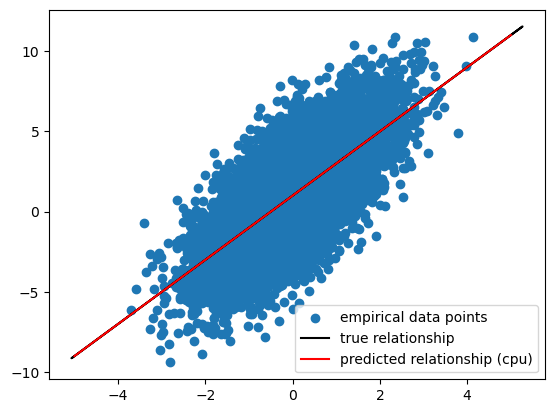

In [17]:
plt.scatter(x[:10000], y_noisy[:10000], label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.legend()

*cuML*

The mathematical operations underlying many machine learning algorithms are often matrix multiplications. These types of operations are highly parallelizable and can be greatly accelerated using a GPU. cuML makes it easy to build machine learning models in an accelerated fashion while still using an interface nearly identical to Scikit-Learn. The below shows how to accomplish the same Linear Regression model but on a GPU.

First, let's convert our data from a NumPy representation to a cuDF representation.

In [18]:
# create a cuDF DataFrame
import cudf
df = cudf.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

          x         y
0  1.214975  0.493893
1 -0.257852 -3.188371
2  0.614914  2.651844
3 -0.717747 -2.383818
4 -0.795688 -1.673264


Next, we'll load the GPU accelerated LinearRegression class from cuML, instantiate it, and fit it to our data.

In [19]:
import cuml; print('cuML Version:', cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegression_GPU


# instantiate and fit model
linear_regression_gpu = LinearRegression_GPU(algorithm = "svd")

cuML Version: 22.08.00


In [20]:
%%time

linear_regression_gpu.fit(df[['x']], df['y'])

CPU times: user 1.15 s, sys: 182 ms, total: 1.33 s
Wall time: 2.65 s


LinearRegression()

We can use this model to predict values for new data points, a step often called "inference" or "scoring". All model fitting and predicting steps are GPU accelerated.

In [21]:
# create new data and perform inference
new_data_df = cudf.DataFrame({'inputs': inputs})
outputs_gpu = linear_regression_gpu.predict(new_data_df[['inputs']])

Lastly, we can overlay our predicted relationship using our GPU accelerated Linear Regression model (green line) over our empirical data points (light blue circles), the true relationship (blue line), and the predicted relationship from a model built on the CPU (red line). We see that our GPU accelerated model's estimate of the true relationship (green line) is identical to the CPU based model's estimate of the true relationship (red line)!

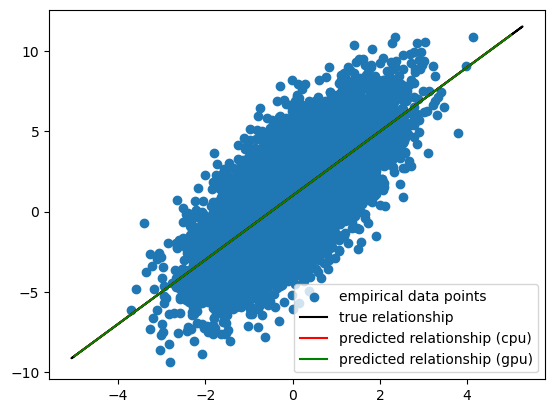

In [22]:
plt.scatter(x[:10000], y_noisy[:10000], label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, outputs_gpu.to_numpy(), color='green', label='predicted relationship (gpu)')
plt.legend()

*Comparing the Performance of CuML and Scikit-Learn*

To finish out this section, let's look at the GPU-accelerated performance speedups for some commonly used machine learning algorithms. CuML has built-in benchmarking capability to help measure performance.

In [23]:
import cuml

from cuml.benchmark.runners import SpeedupComparisonRunner
from cuml.benchmark.algorithms import algorithm_by_name

runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=[2**x for x in range(11, 14)], 
    bench_dims=[256],
    dataset_name="blobs",
    input_type="numpy")

algorithms = ["NearestNeighbors", 
              "DBSCAN", 
              "LinearRegression", 
              "PCA", 
              "RandomForestClassifier"]

for algorithm in algorithms:   
    runner.run(algorithm_by_name(algorithm), verbose=True)

NearestNeighbors (n_samples=2048, n_features=256) [cpu=0.365140438079834, gpu=0.8994054794311523, speedup=0.4059797793435444]
NearestNeighbors (n_samples=4096, n_features=256) [cpu=1.0456089973449707, gpu=0.2591085433959961, speedup=4.03540919045253]
NearestNeighbors (n_samples=8192, n_features=256) [cpu=3.530073642730713, gpu=0.3548102378845215, speedup=9.949187666562288]
DBSCAN (n_samples=2048, n_features=256) [cpu=0.09854531288146973, gpu=0.36109375953674316, speedup=0.27290782595605123]
DBSCAN (n_samples=4096, n_features=256) [cpu=0.35788440704345703, gpu=0.009699583053588867, speedup=36.89688567706413]
DBSCAN (n_samples=8192, n_features=256) [cpu=1.5518321990966797, gpu=0.018910646438598633, speedup=82.06129833453106]
LinearRegression (n_samples=2048, n_features=256) [cpu=0.08667325973510742, gpu=0.3131561279296875, speedup=0.27677331530478]
LinearRegression (n_samples=4096, n_features=256) [cpu=0.06272482872009277, gpu=0.011247634887695312, speedup=5.57671273528913]
LinearRegress

KeyboardInterrupt: 

---

**Please restart the kernel**

In [24]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}